In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import optuna
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import xgboost as xgb

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from optuna.pruners import MedianPruner

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True



---
#**Data Preparation**

**First I load our data into a pandas dataframe and then split them into two classes based on the ratings: {1, 2} -> 'neg' and {4, 5} -> 'pos'.**

In [4]:
# Load your Excel data into a pandas DataFrame
# Replace 'file_path.xlsx' with the actual file path of your Excel sheet
df = pd.read_csv('Review.csv')

# Select only the 'review' and 'rating' columns
df_filtered = df[['Review', 'Rating']]

# Since Rating 1 has the least frequency, we use the same number for all other classes.
val = df_filtered['Rating'].value_counts()[1]

# Balancing class frequencies
df_rating_1 = df_filtered[df_filtered['Rating'] == 1].sample(n=val, random_state=1)
df_rating_2 = df_filtered[df_filtered['Rating'] == 2].sample(n=val, random_state=1)
df_rating_4 = df_filtered[df_filtered['Rating'] == 4].sample(n=val, random_state=1)
df_rating_5 = df_filtered[df_filtered['Rating'] == 5].sample(n=val, random_state=1)

# Combine the samples into a single DataFrame
balanced_df = pd.concat([df_rating_1, df_rating_2, df_rating_4, df_rating_5])

# Relabel the ratings
# 1 and 2 -> neg, 3 -> nil, 4 and 5 -> pos
def relabel_rating(rating):
    if rating in [1, 2]:
        return 'neg'
    elif rating in [4, 5]:
        return 'pos'

# Apply the relabeling function to the 'rating' column
balanced_df['Rating'] = balanced_df['Rating'].apply(relabel_rating)

# Reset the index for neatness
balanced_df.reset_index(drop=True, inplace=True)

# Removing nan values
balanced_df.dropna(inplace=True)

# Display the first few rows of the final DataFrame
print(balanced_df.head())

                                              Review Rating
0  Our 2008 Town & Country shuts off while drivin...    neg
1  I purchased this new in 2012 and paid cash for...    neg
2  Update:  12/28/2019 - GPS/INFOTAINMENT SCREEN ...    neg
3  I thought I was getting a good deal. A mint fu...    neg
4  I have had a rattle in my new VW atlas after t...    neg


In [5]:
balanced_df.shape #Just to make sure that the file has loaded properly

(43960, 2)

**Splitting data into Train, test and validation sets and then relabling 'pos' and 'neg' as 1 and 0 respectively, for later analysis.**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['Review'], balanced_df['Rating'], stratify = balanced_df['Rating'], shuffle = True, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, shuffle = True, test_size=0.25, random_state=3)
y_train = y_train.map({'pos':1,'neg':0})
y_test = y_test.map({'pos':1,'neg':0})
y_val = y_val.map({'pos':1,'neg':0})

**A function for stemming, tokenizing, removing stop words and turning everything to lower case**

In [8]:
def review_cleaner(review):
  stopwords = nltk.corpus.stopwords.words("english")
  porter = PorterStemmer()
  # Make sure the reviews are not case sensitive
  review = review.lower()
  # Tokenize the words from the review
  words = nltk.word_tokenize(review)
  # Stemming and stopwords removal
  processed_words = [porter.stem(word) for word in words if word not in stopwords]
  # Join back to a single string
  return ' '.join(processed_words)



---
#**Random Forest**


**I used Optuna's Optimization Library to perform bayesian optimization on a broad set of hyperparameters.**

**This function performs hyperparameter tuning using Optuna and also creates and uses sparse TFIDF matrix as inputs for Random Forest.**

**Note that I first performed just 50 trials to identify the 'path' of our optimizer and narrow down the feature space for hyperparameter tuning based on the most likely values for maxima**



In [ ]:
def objective(trial):
  # Range of values for Random Forest to try out
  n_estimators = trial.suggest_int('n_estimators', 100, 1000)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
  ngram_max = trial.suggest_int('ngram_range', 1, 3)

  # Defining our Random Forest Classifier model
  model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=3
  )

  # Creating a sparse TF-IDF matrix for training and validation data
  tfidf = TfidfVectorizer(preprocessor=review_cleaner, max_features = 7000, ngram_range = (1, ngram_max))
  X_train_tfidf = tfidf.fit_transform(X_train)
  X_val_tfidf = tfidf.transform(X_val)

  # Fitting on sparse training data and predicting for validation data
  model.fit(X_train_tfidf, y_train)
  y_pred = model.predict(X_val_tfidf)

  # f1 score as metric to optimize
  score = f1_score(y_val, y_pred)
  return score

# We try optimizing our classifier by maximizing the f1 scores
study1_prac = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=45))

# Attempting 50 trials initially for feature bounding
study1_prac.optimize(objective, n_trials=50)

[I 2024-11-14 21:48:27,052] A new study created in memory with name: no-name-ef692d2d-4358-4ac5-95d7-5d9fe1da388b
[I 2024-11-14 21:50:05,658] Trial 0 finished with value: 0.8671943711521548 and parameters: {'n_estimators': 991, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'ngram_range': 1}. Best is trial 0 with value: 0.8671943711521548.
[I 2024-11-14 21:51:35,648] Trial 1 finished with value: 0.8574523396880416 and parameters: {'n_estimators': 247, 'max_depth': 14, 'min_samples_split': 21, 'min_samples_leaf': 28, 'max_features': 'log2', 'ngram_range': 2}. Best is trial 0 with value: 0.8671943711521548.
[I 2024-11-14 21:53:33,056] Trial 2 finished with value: 0.8734939759036144 and parameters: {'n_estimators': 657, 'max_depth': 21, 'min_samples_split': 32, 'min_samples_leaf': 22, 'max_features': 'sqrt', 'ngram_range': 2}. Best is trial 2 with value: 0.8734939759036144.
[I 2024-11-14 21:54:58,352] Trial 3 finished with value: 0.856145708365143

**The initial 'optimal' value achieves 89.91% accuracy**

In [ ]:
# Print the best parameters found
print("Best trial:")
trial = study1_prac.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
Value: 0.8991
Params: 
    n_estimators: 917
    max_depth: 50
    min_samples_split: 24
    min_samples_leaf: 1
    max_features: sqrt
    ngram_range: 2


**I create a pandas dataframe from the different values that were tested out by Optuna. I then use these values to create contour plots to identify the peaks and slopes. This will help us in narrowing down our feature space.**

In [ ]:
study1_prac_df = study1_prac.trials_dataframe()
study1_prac_df.head()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_ngram_range,state
0,0,0.867194,2024-11-14 21:48:27.053852,2024-11-14 21:50:05.658496,0 days 00:01:38.604644,32,log2,3,10,991,1,COMPLETE
1,1,0.857452,2024-11-14 21:50:05.660070,2024-11-14 21:51:35.647949,0 days 00:01:29.987879,14,log2,28,21,247,2,COMPLETE
2,2,0.873494,2024-11-14 21:51:35.649807,2024-11-14 21:53:33.055775,0 days 00:01:57.405968,21,sqrt,22,32,657,2,COMPLETE
3,3,0.856146,2024-11-14 21:53:33.057525,2024-11-14 21:54:58.351870,0 days 00:01:25.294345,19,log2,8,16,201,1,COMPLETE
4,4,0.880293,2024-11-14 21:54:58.353551,2024-11-14 21:57:31.850857,0 days 00:02:33.497306,19,sqrt,4,23,931,3,COMPLETE


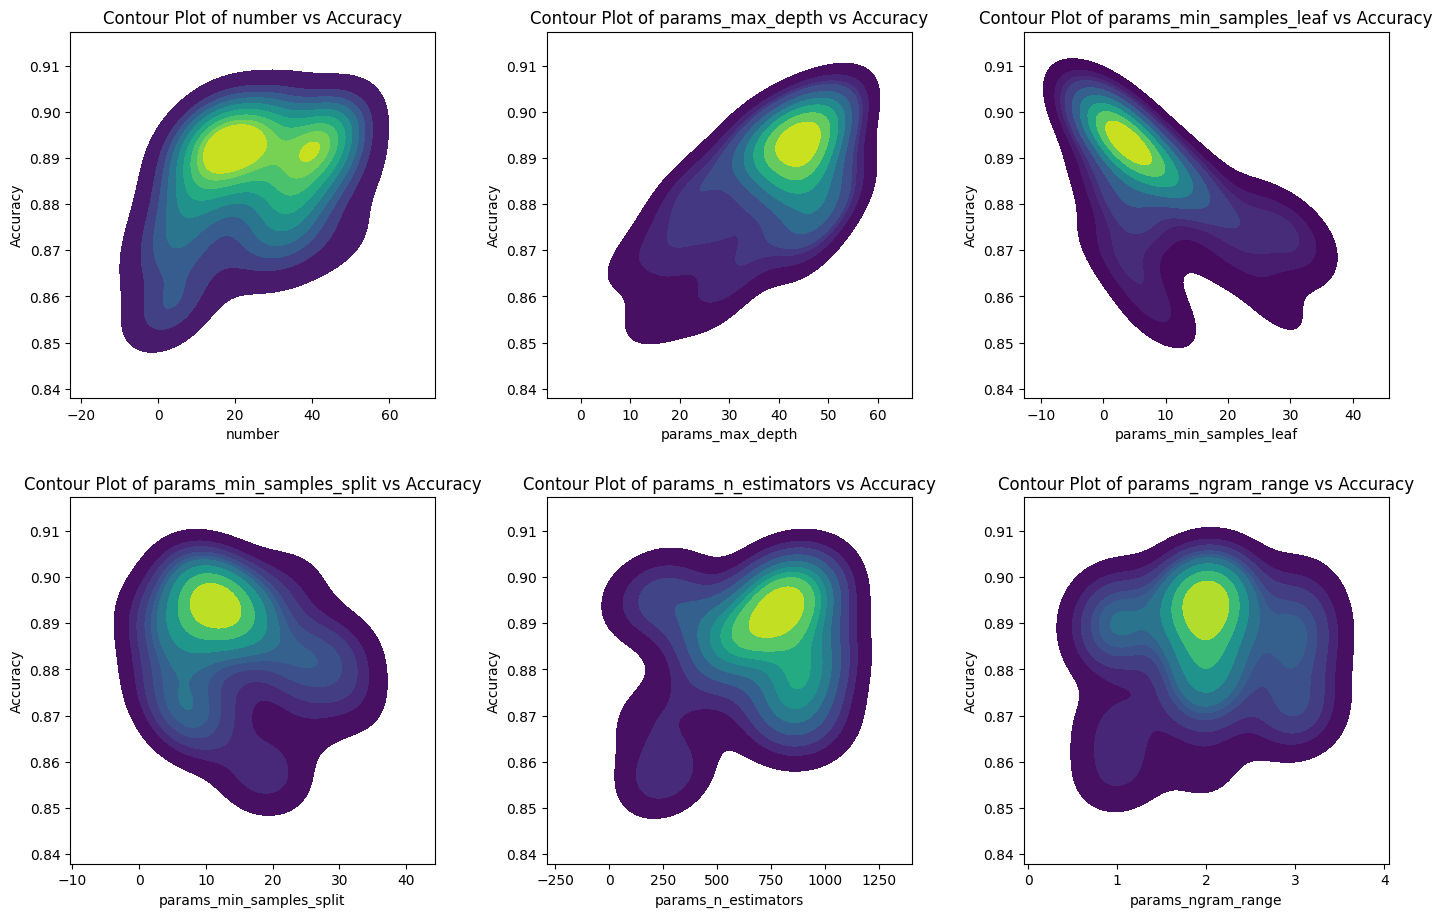

In [ ]:
parameter_columns = [col for col in study1_prac_df.select_dtypes(['int', 'float']).columns if col != 'value']

# Set up the grid layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
fig.tight_layout(pad=5.0)  # Add space between plots for readability

# Loop through each parameter and plot on a grid
for i, param in enumerate(parameter_columns):
    row, col = divmod(i, 3)  # Calculate row and column index in the grid
    sns.kdeplot(
        x=study1_prac_df[param],
        y=study1_prac_df['value'],
        fill=True,
        cmap="viridis",
        ax=axes[row, col]
    )

    # Label each subplot
    axes[row, col].set_xlabel(param)
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].set_title(f'Contour Plot of {param} vs Accuracy')

# Display the grid of plots
plt.show()

**Checking summary stats to get more insights about standard deviation, mean and median values.**

In [ ]:
study1_prac_df.select_dtypes(['int', 'float']).describe()

,number,value,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_ngram_range
count,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,24.50000,0.884571,38.62000,8.580000,13.980000,678.540000,2.000000
std,14.57738,0.011647,10.78527,8.813464,7.895982,256.244798,0.670059
min,0.00000,0.856146,10.00000,1.000000,2.000000,112.000000,1.000000
25%,12.25000,0.877385,32.50000,2.250000,8.000000,503.250000,2.000000
50%,24.50000,0.886707,42.50000,5.000000,12.000000,760.500000,2.000000
75%,36.75000,0.893886,47.00000,11.000000,18.750000,882.250000,2.000000
max,49.00000,0.899133,50.00000,32.000000,32.000000,999.000000,3.000000


In [ ]:
study1_prac_df['params_max_features'].value_counts()

,count
params_max_features,
sqrt,40
log2,10


**Based on the above plots and summary stats, we can reduce the feature space down to the following:**

**ngrams:** bigrams seem to be preferred over unigrams and trigrams

**max_features:** sqrt(n) seems to have been priortized

**n_estimators:** higher number of trees are preferred

**max-depth:** Higher depth is preferred

**min_samples_split** and **min_samples_leaf** can be narrowed down as below as well


In [ ]:
tfidf = TfidfVectorizer(preprocessor=review_cleaner, max_features = 7000, ngram_range = (1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

def objective(trial):
  #Range of values for Random Forest to try out
  n_estimators = trial.suggest_int('n_estimators', 420, 940)
  max_depth = trial.suggest_int('max_depth', 35, 50)
  min_samples_split = trial.suggest_int('min_samples_split', 5, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

  model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features='sqrt',
        random_state=3
  )
  model.fit(X_train_tfidf, y_train)
  y_pred = model.predict(X_val_tfidf)

  # metric  to optimize
  score = f1_score(y_val, y_pred)

  return score

study1 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=45))
study1.optimize(objective, n_trials=100)

[I 2024-11-15 01:24:46,633] A new study created in memory with name: no-name-e8477d53-adc9-4b06-8b2b-3f00c0a4391f
[I 2024-11-15 01:27:53,711] Trial 0 finished with value: 0.8964735230751786 and parameters: {'n_estimators': 935, 'max_depth': 43, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8964735230751786.
[I 2024-11-15 01:29:53,196] Trial 1 finished with value: 0.8955427015991834 and parameters: {'n_estimators': 651, 'max_depth': 42, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8964735230751786.
[I 2024-11-15 01:30:41,458] Trial 2 finished with value: 0.8874262369496142 and parameters: {'n_estimators': 480, 'max_depth': 45, 'min_samples_split': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8964735230751786.
[I 2024-11-15 01:32:52,755] Trial 3 finished with value: 0.8935111914989826 and parameters: {'n_estimators': 936, 'max_depth': 42, 'min_samples_split': 14, 'min_samples_leaf': 5}. Best is trial 0 with va

**Even after a more focused exploration and more trials, we achieved 89.99% accuracy on validation data.**

In [ ]:
# Print the best parameters found
print("Best trial:")
trial = study1.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
Value: 0.8999
Params: 
    n_estimators: 551
    max_depth: 48
    min_samples_split: 7
    min_samples_leaf: 1


**Testing out the model's performance on the test set shows us that the accuracy falls down. This implies that the model is slightly overfitting.**

In [9]:
tfidf = TfidfVectorizer(preprocessor=review_cleaner, max_features = 7000, ngram_range = (1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = RandomForestClassifier(
        n_estimators=551,
        max_depth=48,
        min_samples_split=7,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=3
  )

starttime = time.time()

model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

endtime = time.time()

print(endtime-starttime)
# metric  to optimize
score = f1_score(y_test, y_pred)

172.02811980247498


In [10]:
print(score)

0.8986264048132592




---
#**XGBoost**


**Repeating the same process as Random Forest but with XGBoost this time.**

*Repeating the initial trials to narrow down the feature space.*

In [ ]:
tfidf1 = TfidfVectorizer(preprocessor=review_cleaner, max_features = 7000, ngram_range = (1, 1))
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_val_tfidf1 = tfidf1.transform(X_val)

tfidf2 = TfidfVectorizer(preprocessor=review_cleaner, max_features = 7000, ngram_range = (1, 2))
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_val_tfidf2 = tfidf2.transform(X_val)

tfidf3 = TfidfVectorizer(preprocessor=review_cleaner, max_features = 7000, ngram_range = (1, 3))
X_train_tfidf3 = tfidf3.fit_transform(X_train)
X_val_tfidf3 = tfidf3.transform(X_val)

def objective_xgb(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 600)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
  subsample = trial.suggest_float('subsample', 0.6, 1)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1)
  gamma = trial.suggest_float('gamma', 0, 5)
  reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
  reg_lambda = trial.suggest_int('reg_lambda', 1, 10)
  ngram_max = trial.suggest_int('ngram_range', 1, 3)

  model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=3
  )

  if ngram_max == 1:
    X_train_tfidf = X_train_tfidf1
    X_val_tfidf = X_val_tfidf1
  elif ngram_max == 2:
    X_train_tfidf = X_train_tfidf2
    X_val_tfidf = X_val_tfidf2
  else:
    X_train_tfidf = X_train_tfidf3
    X_val_tfidf = X_val_tfidf3

  model.fit(X_train_tfidf, y_train)
  y_pred = model.predict(X_val_tfidf)

  # metric  to optimize
  score = f1_score(y_val, y_pred)

  return score

study2_prac = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=45))
study2_prac.optimize(objective_xgb, n_trials=35)

[I 2024-11-15 09:41:12,333] A new study created in memory with name: no-name-f7695356-8cd3-493c-b4d0-a7c7b4398c85
[I 2024-11-15 09:42:57,360] Trial 0 finished with value: 0.9168472681647085 and parameters: {'n_estimators': 595, 'max_depth': 32, 'learning_rate': 0.09161971756696821, 'subsample': 0.6309158264316691, 'colsample_bytree': 0.7777877983887213, 'gamma': 2.3640398487774266, 'reg_alpha': 0.04852200090644587, 'reg_lambda': 2, 'ngram_range': 1}. Best is trial 0 with value: 0.9168472681647085.
[I 2024-11-15 09:43:59,562] Trial 1 finished with value: 0.9085740277461906 and parameters: {'n_estimators': 414, 'max_depth': 45, 'learning_rate': 0.19852970211539023, 'subsample': 0.99628867390312, 'colsample_bytree': 0.7881402993615142, 'gamma': 3.091472417836791, 'reg_alpha': 0.2826672065311674, 'reg_lambda': 10, 'ngram_range': 3}. Best is trial 0 with value: 0.9168472681647085.
[I 2024-11-15 09:45:11,908] Trial 2 finished with value: 0.916951859456993 and parameters: {'n_estimators': 320

**The initial search has already achieved 91.82% accuracy on validation set**

In [ ]:
# Print the best parameters found
print("Best trial:")
trial = study2_prac.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
Value: 0.9182
Params: 
    n_estimators: 508
    max_depth: 13
    learning_rate: 0.2762674104269062
    subsample: 0.7477400316289613
    colsample_bytree: 0.7674432832243334
    gamma: 4.176491360145837
    reg_alpha: 0.08001862411131572
    reg_lambda: 3
    ngram_range: 2


**Now studying the contour plots and summary statistics**

In [ ]:
study2_prac_df = study2_prac.trials_dataframe()
study2_prac_df.head()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_n_estimators,params_ngram_range,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.916847,2024-11-15 09:41:12.335101,2024-11-15 09:42:57.359955,0 days 00:01:45.024854,0.777788,2.364040,0.091620,32,595,1,0.048522,2,0.630916,COMPLETE
1,1,0.908574,2024-11-15 09:42:57.362438,2024-11-15 09:43:59.561707,0 days 00:01:02.199269,0.788140,3.091472,0.198530,45,414,3,0.282667,10,0.996289,COMPLETE
2,2,0.916952,2024-11-15 09:43:59.563379,2024-11-15 09:45:11.908308,0 days 00:01:12.344929,0.690782,2.392762,0.157813,21,320,3,0.242758,4,0.644984,COMPLETE
3,3,0.910334,2024-11-15 09:45:11.910155,2024-11-15 09:46:33.475955,0 days 00:01:21.565800,0.644226,3.005021,0.075220,47,137,1,0.406793,9,0.882549,COMPLETE
4,4,0.912509,2024-11-15 09:46:33.477601,2024-11-15 09:48:46.067988,0 days 00:02:12.590387,0.890655,1.550370,0.083066,32,329,1,0.825754,5,0.644097,COMPLETE


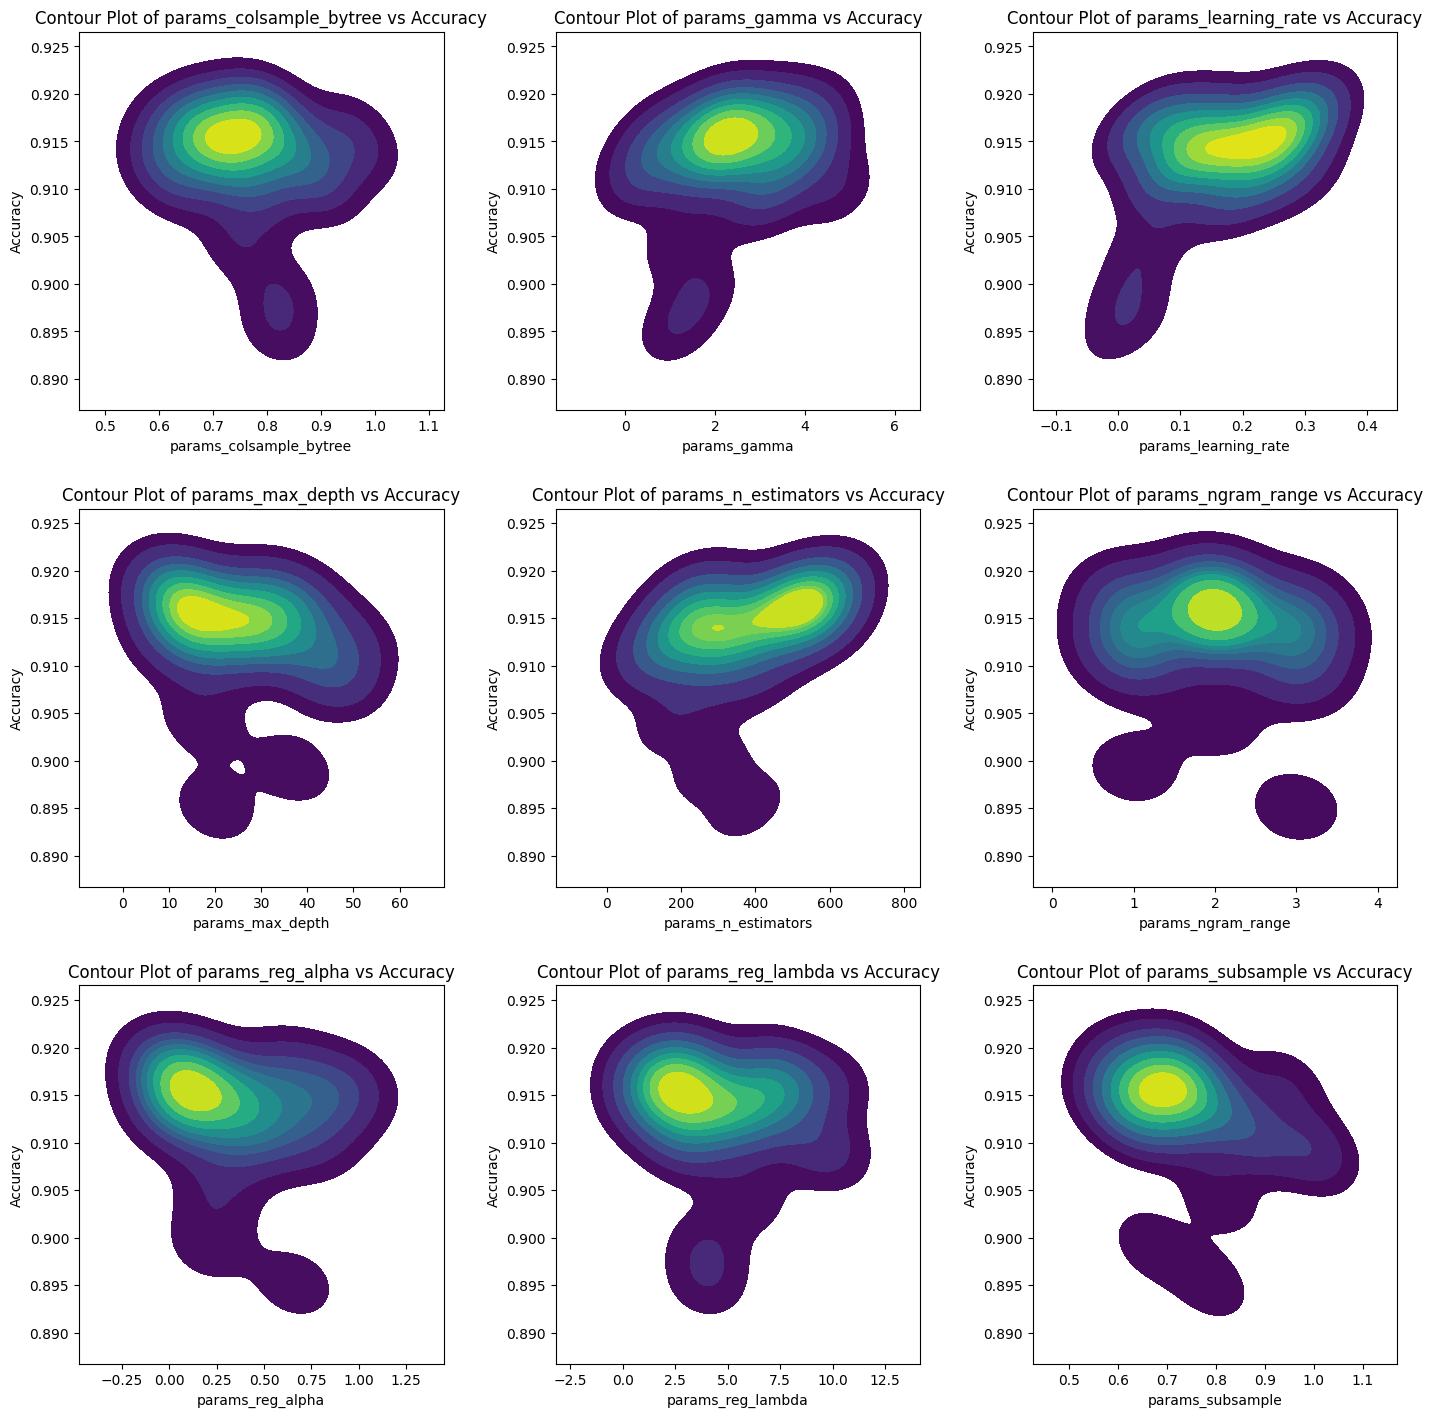

In [ ]:
parameter_columns = [col for col in study2_prac_df.select_dtypes(['int', 'float']).columns if (col != 'value' and col != 'number')]

# Set up the grid layout
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 2 rows, 3 columns
fig.tight_layout(pad=5.0)  # Add space between plots for readability

# Loop through each parameter and plot on a grid
for i, param in enumerate(parameter_columns):
    row, col = divmod(i, 3)  # Calculate row and column index in the grid
    sns.kdeplot(
        x=study2_prac_df[param],
        y=study2_prac_df['value'],
        fill=True,
        cmap="viridis",
        ax=axes[row, col]
    )

    # Label each subplot
    axes[row, col].set_xlabel(param)
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].set_title(f'Contour Plot of {param} vs Accuracy')

# Display the grid of plots
plt.show()

In [ ]:
study2_prac_df.select_dtypes(['int', 'float']).describe()

,number,value,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_n_estimators,params_ngram_range,params_reg_alpha,params_reg_lambda,params_subsample
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,17.000000,0.913326,0.760491,2.425742,0.169878,25.428571,373.000000,1.971429,0.339243,4.600000,0.734845
std,10.246951,0.005046,0.091043,1.123227,0.090058,11.785549,147.925657,0.746983,0.288534,2.522837,0.104692
min,0.000000,0.895106,0.601788,0.320861,0.011362,10.000000,109.000000,1.000000,0.000054,1.000000,0.600206
25%,8.500000,0.912652,0.693678,1.615695,0.095022,14.500000,254.000000,1.000000,0.093353,3.000000,0.649272
50%,17.000000,0.914605,0.767443,2.364040,0.171685,24.000000,362.000000,2.000000,0.261854,4.000000,0.714120
75%,25.500000,0.916201,0.814733,3.266462,0.247299,34.000000,510.000000,2.500000,0.550166,6.500000,0.778821
max,34.000000,0.918175,0.976122,4.704389,0.299794,50.000000,598.000000,3.000000,0.969834,10.000000,0.996289


**We can see the robustness of our accuracies increasing due to the increased number of features. Hence, only ngrams and colsample_bytree were fixed - everything else was just re-searched on a smaller feature space.**

In [ ]:
def objective_xgb(trial):
  n_estimators = trial.suggest_int('n_estimators', 250, 900)
  max_depth = trial.suggest_int('max_depth', 10, 35)
  learning_rate = trial.suggest_float('learning_rate', 0.1, 0.3)
  subsample = trial.suggest_float('subsample', 0.6, 1)
  gamma = trial.suggest_float('gamma', 1, 4)
  reg_alpha = trial.suggest_float('reg_alpha', 0, 0.6)
  reg_lambda = trial.suggest_float('reg_lambda', 1, 7)

  model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=0.75,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=3
  )

  model.fit(X_train_tfidf2, y_train)
  y_pred = model.predict(X_val_tfidf2)

  # metric  to optimize
  score = f1_score(y_val, y_pred)

  return score

study2 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=45))
study2.optimize(objective_xgb, n_trials=150)

# Print the best parameters found
print("Best trial:")
trial = study2_prac.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-15 11:05:35,993] A new study created in memory with name: no-name-56ffe690-b677-4fdc-a053-7aa9714072de
[I 2024-11-15 11:07:11,819] Trial 0 finished with value: 0.9186363636363636 and parameters: {'n_estimators': 893, 'max_depth': 24, 'learning_rate': 0.15628946039101257, 'subsample': 0.6309158264316691, 'gamma': 2.3334084879154093, 'reg_alpha': 0.2836847818532912, 'reg_lambda': 1.2911320054386752}. Best is trial 0 with value: 0.9186363636363636.
[I 2024-11-15 11:07:53,774] Trial 1 finished with value: 0.9185386884501928 and parameters: {'n_estimators': 356, 'max_depth': 13, 'learning_rate': 0.2254783365408852, 'subsample': 0.9424728194382498, 'gamma': 2.9503072632626575, 'reg_alpha': 0.59443301085468, 'reg_lambda': 3.8221044904227126}. Best is trial 0 with value: 0.9186363636363636.
[I 2024-11-15 11:08:44,410] Trial 2 finished with value: 0.9136986301369863 and parameters: {'n_estimators': 652, 'max_depth': 17, 'learning_rate': 0.29520066316350835, 'subsample': 0.86922719965

Best trial:
Value: 0.9182
Params: 
    n_estimators: 508
    max_depth: 13
    learning_rate: 0.2762674104269062
    subsample: 0.7477400316289613
    colsample_bytree: 0.7674432832243334
    gamma: 4.176491360145837
    reg_alpha: 0.08001862411131572
    reg_lambda: 3
    ngram_range: 2


**The accuracy has now increased by 0.46%**

In [ ]:
# Print the best parameters found
print("Best trial:")
trial = study2.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
Value: 0.9228
Params: 
    n_estimators: 899
    max_depth: 11
    learning_rate: 0.10554327473918178
    subsample: 0.9026582904231316
    gamma: 2.774901522744547
    reg_alpha: 0.38903179108291885
    reg_lambda: 1.7600293280027168


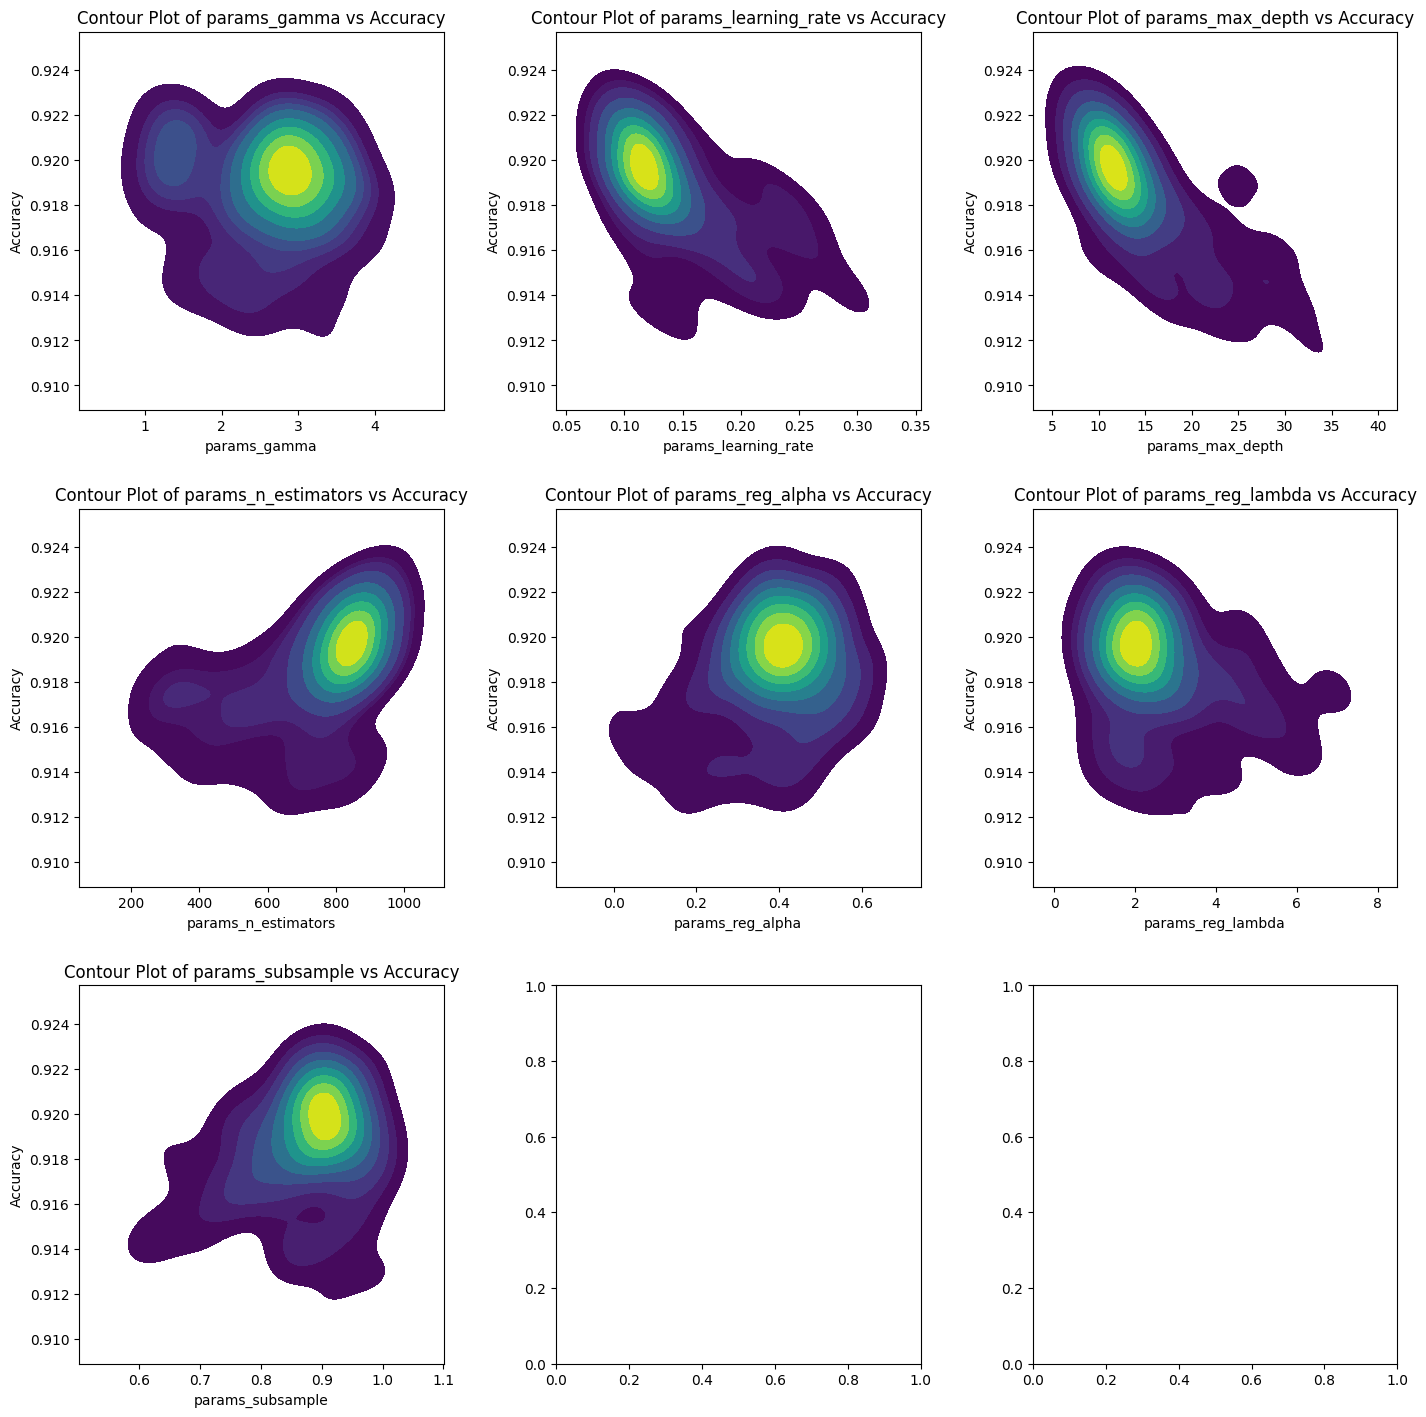

In [ ]:
study2_df = study2.trials_dataframe()

parameter_columns = [col for col in study2_df.select_dtypes(['int', 'float']).columns if (col != 'value' and col != 'number')]

# Set up the grid layout
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 2 rows, 3 columns
fig.tight_layout(pad=5.0)  # Add space between plots for readability

# Loop through each parameter and plot on a grid
for i, param in enumerate(parameter_columns):
    row, col = divmod(i, 3)  # Calculate row and column index in the grid
    sns.kdeplot(
        x=study2_df[param],
        y=study2_df['value'],
        fill=True,
        cmap="viridis",
        ax=axes[row, col]
    )

    # Label each subplot
    axes[row, col].set_xlabel(param)
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].set_title(f'Contour Plot of {param} vs Accuracy')

# Display the grid of plots
plt.show()

**We can see that almost all of our parameters have chosen an optimal value in their given ranges. Further improvement to this performance seems unlikely**



---

**Now, we compare the performance of a XGBoost algorithm made of 900 trees vs. 350 trees. We see that the one made of 900 trees takes ~92 seconds and achieves 91.33% accuracy on test set. Whereas, the one with 350 trees takes almost half the time ~55 seconds to achieve similar (91.03%) accuracy.**

**This shows that smaller trees sizes can be considered for faster performance, albeit at the cost of a  minor loss in accuracy.**

In [ ]:
tfidf2 = TfidfVectorizer(preprocessor=review_cleaner, max_features = 7000, ngram_range = (1, 2))
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2 = tfidf2.transform(X_test)

starttime = time.time()

# A model with a very high number of trees - will be slow but more accurate

model_xgb = XGBClassifier(
      n_estimators=900,
      max_depth=11,
      learning_rate=0.1,
      subsample=0.9,
      colsample_bytree=0.75,
      gamma=2.775,
      reg_alpha=0.4,
      reg_lambda=2,
      random_state=3
)

model_xgb.fit(X_train_tfidf2, y_train)
y_pred = model_xgb.predict(X_test_tfidf2)

endtime = time.time()

# Prints the accuracy of our model on test set
print(f1_score(y_test, y_pred))
# Prints the total time taken
print(endtime-starttime)

0.9133930622559154
91.53390407562256


In [ ]:
starttime = time.time()

# A model with fewer trees for faster performance

model2_xgb = XGBClassifier(
      n_estimators=350,
      max_depth=15,
      learning_rate=0.17,
      subsample=0.9,
      colsample_bytree=0.75,
      gamma=2.775,
      reg_alpha=0.5,
      reg_lambda=2.5,
      random_state=3
)

model2_xgb.fit(X_train_tfidf2, y_train)
y_pred = model2_xgb.predict(X_test_tfidf2)

endtime = time.time()

# Prints the accuracy of our model on test set
print(f1_score(y_test, y_pred))
# Prints the total time taken
print(endtime-starttime)

0.9103226547249972
54.91277289390564




---
#**Ensemble Method**


**In this section, I have chosen to use k-fold cross validation instead of a validation dataset. Hence, using a renewed pair of training and test datasets.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['Review'], balanced_df['Rating'], shuffle = True, test_size=0.2, random_state=3)
y_train = y_train.map({'pos':1,'neg':0})
y_test = y_test.map({'pos':1,'neg':0})

tfidf2 = TfidfVectorizer(preprocessor=review_cleaner, max_features = 7000, ngram_range = (1, 2))
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2 = tfidf2.transform(X_test)



---
####**Ensemble #1 - Rain forest + XGB + Logisitc Regression**

*Note that I have used the tuned parameters from previous section - which is not ideal. Hyperparameter tuning could be repeated to choose the ideal parameters.*

In [ ]:
starttime = time.time()

# Define base models
base_estimators = [
    ('rf', model),
    ('xgb', model_xgb)
]
# Stacking Classifier
ensemble_model_LR = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(C = 1, l1_ratio = 0.1, max_iter = 200, solver = 'saga', penalty = 'elasticnet'),
    cv=3,
    verbose = 2
)

ensemble_model_LR.fit(X_train_tfidf2, y_train)

y_pred_LR = ensemble_model_LR.predict(X_test_tfidf2)

endtime = time.time()

print(f1_score(y_test, y_pred_LR))
print(endtime-starttime)

0.9156695156695157
471.1438934803009


**Achieves 91.57% accuracy. However, since the model had to fit for RF, XGB and LR, it takes considerable amount of time.**



---
####**Ensemble #2 - Random Forest + XGBoost + Linear SVC**
*Note that I have used the tuned parameters from previous section - which is not ideal. Hyperparameter tuning could be repeated to choose the ideal parameters.*

In [ ]:
starttime = time.time()

# Define base models
base_estimators = [
    ('rf', model),
    ('xgb', model_xgb)
]
# Stacking Classifier
ensemble_model_svc = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LinearSVC(C = 0.1, penalty = 'l2', max_iter = 2000),
    cv=3,
    verbose = 2
)

ensemble_model_svc.fit(X_train_tfidf2, y_train)

y_pred_svc = ensemble_model_svc.predict(X_test_tfidf2)

endtime = time.time()

print(f1_score(y_test, y_pred_svc))
print(endtime-starttime)

0.9158958303685784
467.93009328842163


**Achieves 91.59% accuracy - near identical to Ensemble #1. However, since the model had to fit for RF, XGB and LSVC, it takes considerable amount of time.**



---
####**Ensemble #3 - Random Forest + XGBoost + Multinomial NB**
*Note that I have used the tuned parameters from previous section - which is not ideal. Hyperparameter tuning could be repeated to choose the ideal parameters.*

In [ ]:
starttime = time.time()

# Define base models
base_estimators = [
    ('rf', model),
    ('xgb', model_xgb)
]
# Stacking Classifier
ensemble_model_NB = StackingClassifier(
    estimators=base_estimators,
    final_estimator=MultinomialNB(alpha = 0.1),
    cv=3,
    verbose = 2
)

ensemble_model_NB.fit(X_train_tfidf2, y_train)

y_pred_NB = ensemble_model_NB.predict(X_test_tfidf2)

endtime = time.time()

print(f1_score(y_test, y_pred_NB))
print(endtime-starttime)

0.9051795012332146
468.60425877571106


**As partly expected, this performed worse than LR and LSVC**

---
#**XGBoost with custom Word2Vec Embeddings**

**The goal is to use word2vec to reduce the number of features from 7000 to 300. This will hopefully speed up our calculations and achieve similar levels of accuracy.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['Review'], balanced_df['Rating'], shuffle = True, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True, test_size=0.25, random_state=3)
y_train = y_train.map({'pos':1,'neg':0})
y_test = y_test.map({'pos':1,'neg':0})
y_val = y_val.map({'pos':1,'neg':0})

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import re

# Preprocess and tokenize the documents
def preprocess_text(text):
    # Basic cleaning - lowercasing, removing non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    return tokens

# Tokenize each document in your corpus
tokenized_documents = [preprocess_text(reviews) for reviews in X_train]

# Train a Word2Vec model on the tokenized data
w2v_model = Word2Vec(
    sentences=tokenized_documents,
    vector_size=300,      # Dimensionality of the word vectors
    window=5,             # Context window size
    min_count=2,          # Ignores words with total frequency lower than this
    sg=1                  # Use skip-gram (1) instead of CBOW (0)
)

# Save the model for future use
w2v_model.save("custom_word2vec_model.model")


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec


# Custom transformer to average Word2Vec embeddings
class Word2VecAveraging(BaseEstimator, TransformerMixin):
    def __init__(self, w2v_model, vector_size=300):
        self.w2v_model = w2v_model
        self.vector_size = vector_size

    def transform(self, X, y=None):
        return np.array([self._average_word_vectors(text) for text in X])

    def fit(self, X, y=None):
        return self

    def _average_word_vectors(self, text):
        words = text.split()  # Tokenize or use a more advanced tokenizer
        word_vecs = [self.w2v_model.wv[word] for word in words if word in self.w2v_model.wv]

        # If no words in the text are in the Word2Vec vocab, return a zero vector
        if not word_vecs:
            return np.zeros(self.vector_size)

        # Average the word vectors
        return np.mean(word_vecs, axis=0)

# Assuming `w2v_model` is your trained Word2Vec model
w2v_model = Word2Vec.load("custom_word2vec_model.model")

**The smaller number of features allows us to search over a wider set of hyperparameters and trials. First I ran a standard hyperparameter tuning like previous algorithms.**

In [ ]:
w2v_custom_model = Word2VecAveraging(w2v_model=w2v_model, vector_size=300)
w2v_custom_model.fit(X_train)
X_train_w2v = w2v_custom_model.transform(X_train)
X_val_w2v = w2v_custom_model.transform(X_val)

def objective_w2v(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 600)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
  subsample = trial.suggest_float('subsample', 0.5, 1)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1)
  gamma = trial.suggest_float('gamma', 0, 5)
  reg_alpha = trial.suggest_float('reg_alpha', 0, 10)
  reg_lambda = trial.suggest_float('reg_lambda', 0, 10)

  model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=3
  )

  model.fit(X_train_w2v, y_train)
  y_pred = model.predict(X_val_w2v)

  # metric  to optimize
  score = f1_score(y_val, y_pred)

  return score

study3_prac = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=45), pruner = MedianPruner())
study3_prac.optimize(objective_w2v, n_trials=200)

[I 2024-11-16 01:20:19,163] A new study created in memory with name: no-name-1d8316a3-1269-45dd-be07-2bf2ac151f3a
[I 2024-11-16 01:20:30,750] Trial 0 finished with value: 0.89136649514008 and parameters: {'n_estimators': 595, 'max_depth': 32, 'learning_rate': 0.09161971756696821, 'subsample': 0.5386447830395864, 'colsample_bytree': 0.7222347479859015, 'gamma': 2.3640398487774266, 'reg_alpha': 0.4852200090644587, 'reg_lambda': 1.6332444820826675}. Best is trial 0 with value: 0.89136649514008.
[I 2024-11-16 01:20:36,284] Trial 1 finished with value: 0.8864186974490523 and parameters: {'n_estimators': 158, 'max_depth': 35, 'learning_rate': 0.25829279409273104, 'subsample': 0.8250512105437763, 'colsample_bytree': 0.9953608423789, 'gamma': 2.351753742018927, 'reg_alpha': 6.182944835673582, 'reg_lambda': 2.8266720653116737}. Best is trial 0 with value: 0.89136649514008.
[I 2024-11-16 01:20:53,640] Trial 2 finished with value: 0.8903170522707797 and parameters: {'n_estimators': 588, 'max_dept

In [ ]:
# Print the best parameters found
print("Best trial:")
trial = study3_prac.best_trial

print("Value: {:.4f}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
Value: 0.8967
Params: 
    n_estimators: 523
    max_depth: 32
    learning_rate: 0.10115508775449467
    subsample: 0.6389326797564003
    colsample_bytree: 0.8099495330994653
    gamma: 2.103230341802561
    reg_alpha: 9.273608924235784
    reg_lambda: 9.498063121336576


**The model seems to be stuck at around the ~89.5% accuracy and it seems the model preferred higher number of estimator trees. Hence, repeating trials with a wider set of parameters and higher number of trials.**

In [ ]:
def objective_w2v(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 1000)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
  subsample = trial.suggest_float('subsample', 0.6, 1)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1)
  min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
  gamma = trial.suggest_float('gamma', 0, 5)
  reg_alpha = trial.suggest_float('reg_alpha', 0, 10)
  reg_lambda = trial.suggest_float('reg_lambda', 0, 10)

  model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=3,
        early_stopping_rounds=50
  )

  model.fit(X_train_w2v, y_train, eval_set=[(X_val_w2v, y_val)], verbose=False)

  # metric  to optimize

  return model.score(X_val_w2v, y_val)

study3_prac2 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=45), pruner = MedianPruner())
study3_prac2.optimize(objective_w2v, n_trials=500)

[I 2024-11-16 02:06:50,771] A new study created in memory with name: no-name-f9f61854-97df-44b0-82f4-c4730a74d5c5
[I 2024-11-16 02:07:54,366] Trial 0 finished with value: 0.8885106382978724 and parameters: {'n_estimators': 991, 'max_depth': 32, 'learning_rate': 0.026045445589024878, 'subsample': 0.6309158264316691, 'colsample_bytree': 0.7777877983887213, 'min_child_weight': 5, 'gamma': 0.24261000453222936, 'reg_alpha': 1.6332444820826675, 'reg_lambda': 1.1595071149794445}. Best is trial 0 with value: 0.8885106382978724.
[I 2024-11-16 02:08:06,745] Trial 1 finished with value: 0.8876595744680851 and parameters: {'n_estimators': 665, 'max_depth': 45, 'learning_rate': 0.09125992424601813, 'subsample': 0.99628867390312, 'colsample_bytree': 0.7881402993615142, 'min_child_weight': 7, 'gamma': 1.4133360326558368, 'reg_alpha': 9.760033158175416, 'reg_lambda': 6.7306799913167525}. Best is trial 0 with value: 0.8885106382978724.
[I 2024-11-16 02:08:35,506] Trial 2 finished with value: 0.89475177

**Unfortunately, the tuning timed out. However, yet again, the accuracy seems to be timed out below 90%. The best value found was as follows:**

In [ ]:
# Trial 143 finished with value: 0.8984397163120568 and parameters: {
#     'n_estimators': 941,
#     'max_depth': 30,
#     'learning_rate': 0.0410651240984318,
#     'subsample': 0.6099140056714814,
#     'colsample_bytree': 0.7968023178570813,
#     'min_child_weight': 3,
#     'gamma': 1.1370611446424017,
#     'reg_alpha': 7.114077597430731,
#     'reg_lambda': 9.521561968068557}.

w2v_custom_model = Word2VecAveraging(w2v_model=w2v_model, vector_size=300)
w2v_custom_model.fit(X_train)
X_train_w2v = w2v_custom_model.transform(X_train)
X_test_w2v = w2v_custom_model.transform(X_test)

starttime = time.time()

model_w2v = XGBClassifier(
      n_estimators=941,
      max_depth=30,
      learning_rate=0.0410651240984318,
      subsample=0.6099140056714814,
      colsample_bytree=0.7968023178570813,
      min_child_weight = 3,
      gamma=1.1370611446424017,
      reg_alpha=7.114077597430731,
      reg_lambda=9.521561968068557,
      random_state=3
)

model_w2v.fit(X_train_w2v, y_train)
y_pred = model_w2v.predict(X_test_w2v)

endtime = time.time()

# Prints the accuracy of our model on test set
print(f1_score(y_test, y_pred))
# Prints the total time taken
print(endtime-starttime)

0.894459706959707
35.89686560630798


In [ ]:
starttime = time.time()

model1_w2v = XGBClassifier(
    n_estimators= 523,
    max_depth= 32,
    learning_rate= 0.10115508775449467,
    subsample= 0.6389326797564003,
    colsample_bytree= 0.8099495330994653,
    gamma= 2.103230341802561,
    reg_alpha= 9.273608924235784,
    reg_lambda= 9.498063121336576,
    random_state=3
)

model1_w2v.fit(X_train_w2v, y_train)
y_pred = model1_w2v.predict(X_test_w2v)

endtime = time.time()

# Prints the accuracy of our model on test set
print(f1_score(y_test, y_pred))
# Prints the total time taken
print(endtime-starttime)

0.8927058284667354
13.455870866775513


**As we can see, even with a ridiculously high number of trees and maximum depth, the algorithm took lower time than the faster version of earlier XGBoost with TFIDF classifier.**

**There is a certain sweet-spot that can be achieved where the accuracy loss is not bad for the amount of time saved. But can be adjusted based on need.**

**In fact, we can speed-up the process even further if we use smaller and fewer trees for this implementation. However, as one would expect, it comes at the cost of accuracy.**

In [ ]:
X_test_w2v = w2v_custom_model.transform(X_test)

starttime = time.time()

model2_w2v = XGBClassifier(
      n_estimators=250,
      max_depth=14,
      learning_rate=0.02405035302549553,
      subsample=0.6191333926385136,
      colsample_bytree=0.7064408860245562,
      min_child_weight = 5,
      gamma=0.9967079676854492,
      reg_alpha=5.322417563828719,
      reg_lambda=8.148857073587433,
      random_state=3
)

model2_w2v.fit(X_train_w2v, y_train)
y_pred = model2_w2v.predict(X_test_w2v)

endtime = time.time()
# metric  to optimize
print(f1_score(y_test, y_pred))
print(endtime-starttime)

0.8839766349788112
15.058751583099365


In [ ]:
X_test_w2v = w2v_custom_model.transform(X_test)

starttime = time.time()

model3_w2v = XGBClassifier(
      n_estimators=100,
      max_depth=14,
      learning_rate=0.02405035302549553,
      subsample=0.6191333926385136,
      colsample_bytree=0.7064408860245562,
      min_child_weight = 5,
      gamma=0.9967079676854492,
      reg_alpha=5.322417563828719,
      reg_lambda=8.148857073587433,
      random_state=3
)

model3_w2v.fit(X_train_w2v, y_train)
y_pred = model3_w2v.predict(X_test_w2v)

endtime = time.time()
# metric  to optimize
print(f1_score(y_test, y_pred))
print(endtime-starttime)

0.8720054757015743
7.562920093536377




---
#**Feature Importance**

**We can look at the most used features in Random Forest and XGB to understand what words were deemed 'most important' to make a split.**


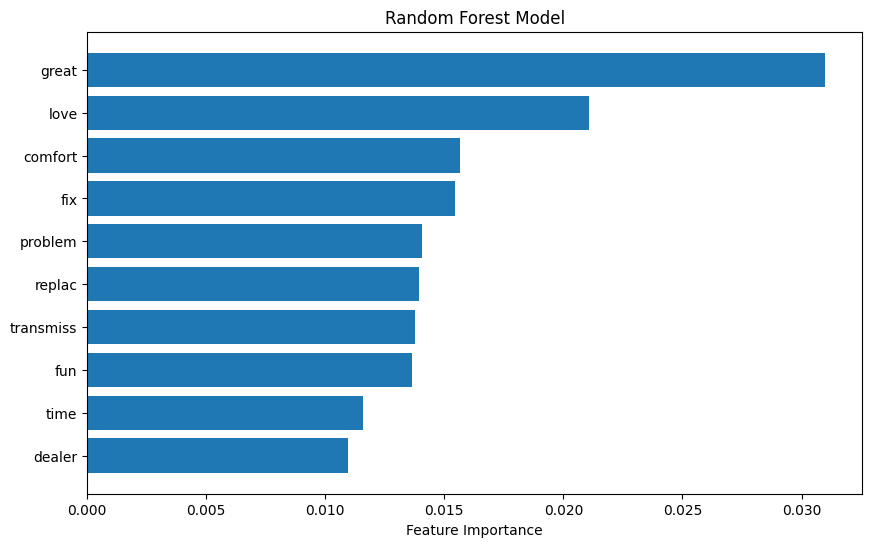

In [ ]:
feature_importances_rf = model.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[-10:]  # Top 10 features
plt.figure(figsize=(10, 6))
plt.title('Random Forest Model')
plt.barh(range(len(indices_rf)), feature_importances_rf[indices_rf], align="center")
plt.yticks(range(len(indices_rf)), [tfidf.get_feature_names_out()[i] for i in indices_rf])
plt.xlabel("Feature Importance")
plt.show()

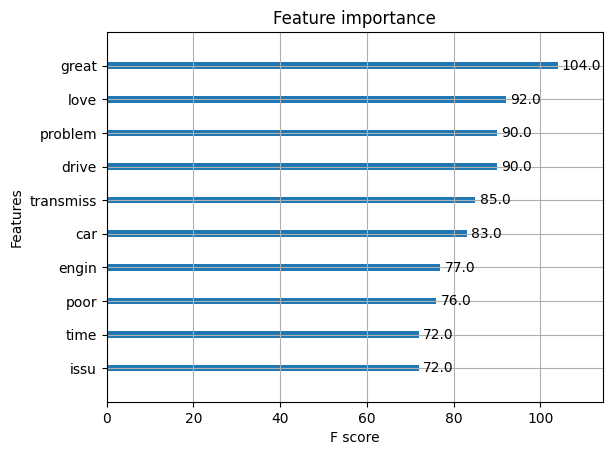

In [ ]:
# Plot feature importance and get Axes object
ax = xgb.plot_importance(model_xgb, max_num_features=10, importance_type="weight")

# Get top feature indices from the plot
top_features = np.array([int(tick.get_text()[1:]) for tick in ax.get_yticklabels()])

# Map feature indices to actual feature names from the vectorizer
feature_names = tfidf2.get_feature_names_out()
top_feature_names = [feature_names[i] for i in top_features]

# Replace tick labels with actual feature names
ax.set_yticklabels(top_feature_names)
plt.show()

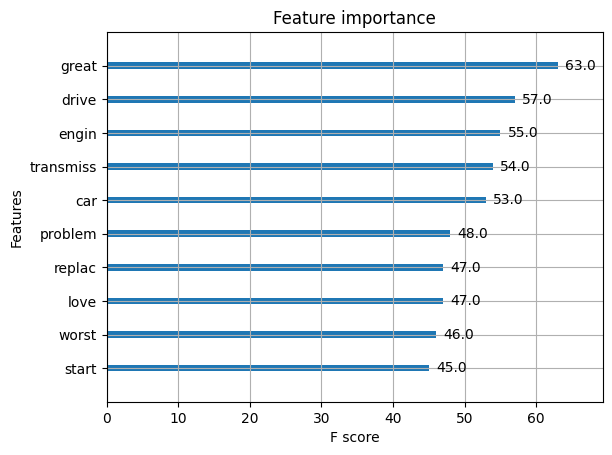

In [ ]:
# Plot feature importance and get Axes object
ax = xgb.plot_importance(model2_xgb, max_num_features=10, importance_type="weight")

# Get top feature indices from the plot
top_features = np.array([int(tick.get_text()[1:]) for tick in ax.get_yticklabels()])

# Map feature indices to actual feature names from the vectorizer
feature_names = tfidf2.get_feature_names_out()
top_feature_names = [feature_names[i] for i in top_features]

# Replace tick labels with actual feature names
ax.set_yticklabels(top_feature_names)
plt.show()

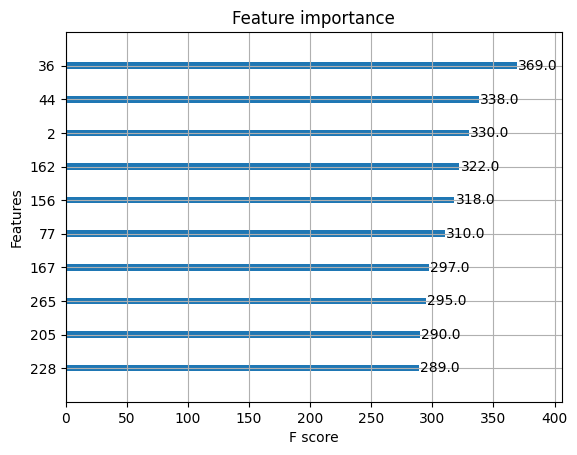

In [ ]:
# Plot feature importance and get Axes object
ax = xgb.plot_importance(model_w2v, max_num_features=10, importance_type="weight")

# Get top feature indices from the plot
top_features = np.array([int(tick.get_text()[1:]) for tick in ax.get_yticklabels()])

# Replace tick labels with actual feature names
ax.set_yticklabels(top_features)
plt.show()

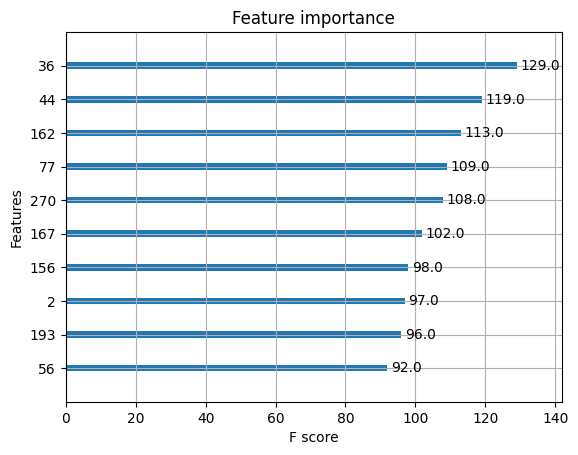

In [ ]:
# Plot feature importance and get Axes object
ax = xgb.plot_importance(model1_w2v, max_num_features=10, importance_type="weight")

# Get top feature indices from the plot
top_features = np.array([int(tick.get_text()[1:]) for tick in ax.get_yticklabels()])

# Replace tick labels with actual feature names
ax.set_yticklabels(top_features)
plt.show()